In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:

# --- 1. Load the Dataset ---
print("Loading dataset...")
df = pd.read_csv('options_dataset.csv')

# Calculate the 99th percentile of the market price
price_cap = df['marketPrice'].quantile(0.99)
print(f"Original number of rows: {len(df)}")
print(f"Removing options priced higher than the 99th percentile: ${price_cap:.2f}")

# Create a new, filtered DataFrame
df_filtered = df[df['marketPrice'] < price_cap]
print(f"New number of rows after filtering: {len(df_filtered)}")

# print(f"Dataset loaded successfully with {len(df)} rows.")

# Display the first few rows to inspect the data
# df.head()

Loading dataset...
Original number of rows: 118274
Removing options priced higher than the 99th percentile: $772.08
New number of rows after filtering: 117090


In [3]:
# Show descriptive statistics for the option prices
df['marketPrice'].describe()

count    118274.000000
mean         89.962287
std         147.278117
min           0.015000
25%           4.167500
50%          32.950000
75%         113.875000
max        1202.000000
Name: marketPrice, dtype: float64

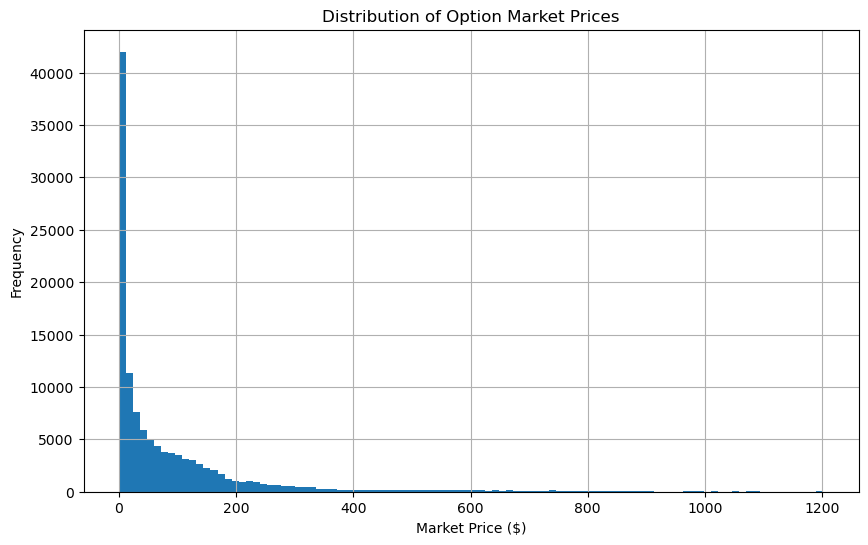

In [4]:
# Plot a histogram to see the distribution of prices
df['marketPrice'].hist(bins=100, figsize=(10,6))
plt.title('Distribution of Option Market Prices')
plt.xlabel('Market Price ($)')
plt.ylabel('Frequency')
plt.show()

In [5]:

# --- 2. Define Features (X) and Target (y) ---
features = [
    'moneyness',
    'timeToExpiration', 
    'impliedVolatility', 
    'riskFreeRate'
    ]
target = 'marketPrice'
X = df_filtered[features]
y = df_filtered[target]

# np.log1p is better than np.log because it handles values of 0 gracefully.
y_log = np.log1p(y)

In [6]:
# --- 3. Split Data into Training and Testing Sets ---

# FIRST, we split the original, non-transformed data.
# This creates our perfectly aligned training and testing sets.
# y_test now holds the true dollar values we need for our final evaluation.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# SECOND, now that the split is done, we create the log-transformed
# version of y_train for the model to train on. We don't need to
# transform y_test.
y_train_log = np.log1p(y_train)

print(f"Data split into {len(X_train)} training samples and {len(X_test)} testing samples.")

Data split into 93672 training samples and 23418 testing samples.


In [7]:

# --- 4. Initialize and Train the Random Forest Model ---
print("Training the Random Forest model... (This may take a few moments)")
# n_estimators: The number of trees in the forest. 100 is a good start.
# n_jobs=-1: This tells the model to use all available CPU cores for training, making it much faster.
# random_state=42: Ensures that your results are reproducible.
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, oob_score=True)

# Fit the model to the training data
# rf_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train_log) # Train on y_train_log
print("Model training complete.")
print(f"Out-of-Bag Score: {rf_model.oob_score_:.4f}")

Training the Random Forest model... (This may take a few moments)
Model training complete.
Out-of-Bag Score: 0.8752


In [8]:

# Make predictions in log space
log_predictions = rf_model.predict(X_test)

# Transform predictions back to the original dollar scale using np.expm1
predictions = np.expm1(log_predictions)

print("\n--- Model Performance Evaluation ---")
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)

print(f"Mean Absolute Error (MAE): ${mae:.4f}")
print(f"Root Mean Squared Error (RMSE): ${rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")
print("------------------------------------")


--- Model Performance Evaluation ---
Mean Absolute Error (MAE): $12.1841
Root Mean Squared Error (RMSE): $33.5975
R-squared (R²): 0.9277
------------------------------------


### 7. Visualize Predictions vs. Actuals

A scatter plot is a great way to see how well the model's predictions align with the true market prices. A perfect model would have all the points lying on the red `y=x` line.

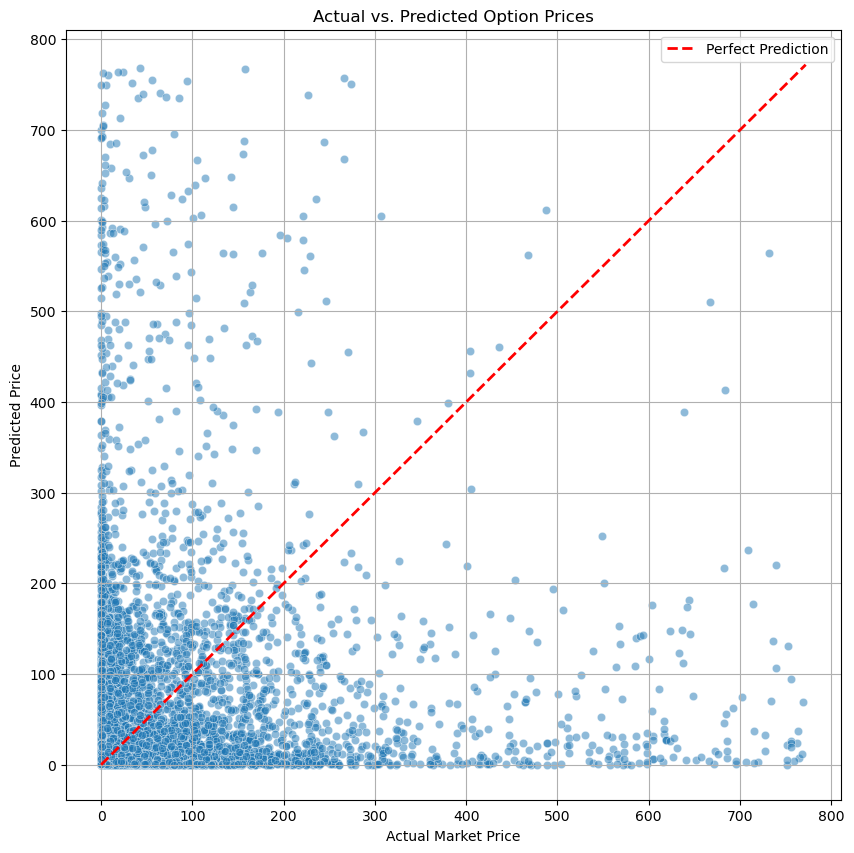

In [9]:
# For performance, we'll only plot a random sample of 5000 points
sample_indices = np.random.choice(X_test.index, 5000, replace=False)

plt.figure(figsize=(10, 10))
sns.scatterplot(x=y_test.loc[sample_indices], y=predictions[X_test.index.isin(sample_indices)], alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Market Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs. Predicted Option Prices')
plt.legend()
plt.grid(True)
plt.show()

--- Feature Importance ---
             Feature  Importance
2  impliedVolatility    0.454576
0          moneyness    0.357453
1   timeToExpiration    0.187971
3       riskFreeRate    0.000000
--------------------------


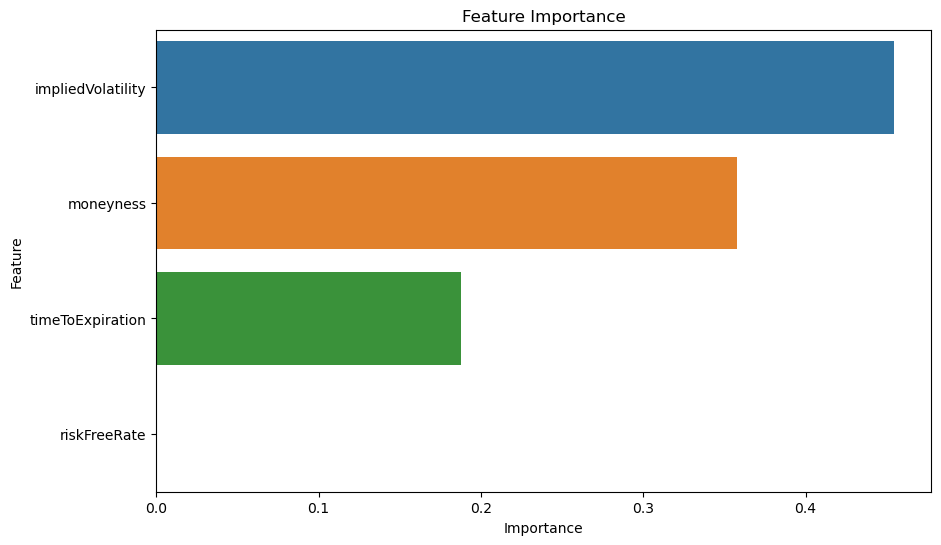

In [10]:
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("--- Feature Importance ---")
print(feature_importance_df)
print("--------------------------")

# Visualize Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()